In [1]:
from tqdm import tqdm
import train_models
from loaddata import MaskDataset
from networks import LC
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.backends.cudnn as cudnn
from easydict import EasyDict
from flags import args

import umap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
def train_lc_model(
    single_img_masks_path,
    adv_labels,
    epochs, 
    batch_size,
    lr, 
    schedule=None,
    weight_decay=0.
):
    
    # GPU configs
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.cuda.empty_cache()
    train_models.fix_seeds(args.seed)

    # get the data
    single_img_masks = torch.load(single_img_masks_path, map_location='cpu')
    dataset = MaskDataset(single_img_masks, adv_labels)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    trainset, testset = random_split(
        dataset, 
        [int(len(dataset)*0.85), len(dataset)-int(len(dataset)*0.85)]
    )
    trainloader = DataLoader(
        trainset, 
        batch_size=batch_size, 
        shuffle=True
    )
    testloader = DataLoader(
        testset, 
        batch_size=batch_size, 
        shuffle=False
    )
    
    # get model
    model = LC(args.img_size, num_classes=5)
    model = model.to(device)
    cudnn.benchmark = True
    
    # optimization configs
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=lr,
        weight_decay=weight_decay
    )
    
    # learning rate scheduling
    if schedule:
        sched = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            lr, 
            epochs=epochs,
            steps_per_epoch=len(trainloader),
            pct_start=schedule
        )
    else: sched = False
    
    # prep results
    logs = EasyDict(
        train_loss=[], 
        test_loss=[], 
        train_accuracy=[], 
        test_accuracy=[]
    )

    # Train
    iterbar = tqdm(range(1, epochs + 1), total=epochs)
    for epoch in iterbar:
        
        trainlogs = train_models.epoch_train(
            model, 
            trainloader, 
            optimizer, 
            lossfunction,
            sched,
            None,
            device
        )
        testlogs = train_models.epoch_test(
            model, 
            testloader,
            lossfunction,
            device
        )
        logs.train_loss.append(trainlogs.loss)
        logs.test_loss.append(testlogs.loss)
        logs.train_accuracy.append(trainlogs.accuracy)
        logs.test_accuracy.append(testlogs.accuracy)
        
        description = f'Train Loss: {trainlogs.loss:.2f} - '\
                      f'Test Loss: {testlogs.loss:.2f} - '\
                      f'Train Acc: {trainlogs.accuracy:.2f}% - '\
                      f'Test Acc: {testlogs.accuracy:.2f}%'
        
        iterbar.set_description(desc=description)
    
    model.eval()
    out_data = EasyDict(
        model_outs=torch.zeros(len(dataloader.dataset), 5), 
        targets=torch.zeros(len(dataloader.dataset)).long()
    )
    correct = 0
    bs = dataloader.batch_size
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs).detach().cpu()
            out_data.model_outs[bs*i: bs*i + inputs.shape[0]] = outputs
            out_data.targets[bs*i: bs*i + inputs.shape[0]] = targets

    del model
    return out_data

In [6]:
architecture = 'resnet'

out_data = train_lc_model(
    single_img_masks_path=f'trained_single_img_masks/{architecture}_single_img_masks.pt',
    adv_labels=False,
    epochs=20, 
    batch_size=32,
    lr=0.001, 
    schedule=0.1,
    weight_decay=5e-3
)
adv_out_data = train_lc_model(
    single_img_masks_path=f'trained_single_img_masks/{architecture}_single_img_masks.pt',
    adv_labels=True,
    epochs=20, 
    batch_size=32,
    lr=0.001, 
    schedule=0.1,
    weight_decay=5e-3
)

Train Loss: 0.51 - Test Loss: 0.82 - Train Acc: 93.76% - Test Acc: 78.44%: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]
Train Loss: 1.61 - Test Loss: 1.62 - Train Acc: 19.85% - Test Acc: 15.60%: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


In [7]:
out_data.model_outs = out_data.model_outs.view(out_data.model_outs.shape[0], -1)
um = umap.UMAP(n_components=2, n_neighbors=20, random_state=42).fit_transform(out_data.model_outs)

adv_out_data.model_outs = adv_out_data.model_outs.view(adv_out_data.model_outs.shape[0], -1)
adv_um = umap.UMAP(n_components=2, n_neighbors=20, random_state=42).fit_transform(adv_out_data.model_outs)

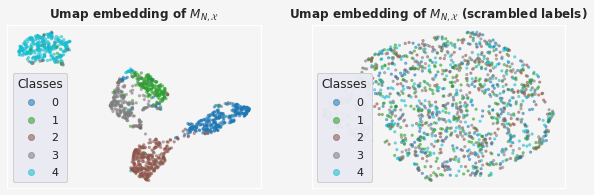

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), facecolor='whitesmoke')

axs[0].set_facecolor('whitesmoke')
scatter = axs[0].scatter(
    um[:, 0], 
    um[:, 1], 
    s=5, 
    c=out_data.targets, 
    cmap='tab10', 
    alpha=0.5
)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title(
    "Umap embedding of $M_{N, \mathcal{X}}$", 
    weight='bold'
)

legend = axs[0].legend(
    *scatter.legend_elements(),
    loc="best", 
    title="Classes"
)
axs[0].add_artist(legend)

axs[1].set_facecolor('whitesmoke')
scatter = axs[1].scatter(
    adv_um[:, 0], 
    adv_um[:, 1], 
    s=5, 
    c=adv_out_data.targets, 
    cmap='tab10', 
    alpha=0.5
)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title(
    "Umap embedding of $M_{N, \mathcal{X}}$ (scrambled labels)", 
    weight='bold'
)

legend = axs[1].legend(
    *scatter.legend_elements(),
    loc="best", 
    title="Classes"
)
axs[1].add_artist(legend)

plt.savefig(
    f'figs/{architecture}_umap.png', 
    dpi=300, 
    bbox_inches='tight'
)
plt.show()